In [43]:
%matplotlib notebook

import os
import sys 
import time
from collections import OrderedDict
from importlib import reload

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

from IPython.display import clear_output

import qcodes as qc
from qcodes.dataset.database import initialise_database, get_DB_location
from qcodes import new_experiment, Station, Instrument
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter, time_trace

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
#from qcodes.instrument_drivers.stanford_research.SR860 import SR860
from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430, AMI430_3D

from pytopo.qctools import instruments as instools

In [6]:
sys.path.append(r"Z:\OneDrive\BF3\Code\labtools-master")

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

In [8]:
sys.path.append(r"Z:\OneDrive\BF3\Code")  # we do this dirt only for "v2_dataset_tools" package to be on path

from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

In [9]:
sys.path.append(r'Z:\OneDrive\BF3\Code\BF3\Experiments\Lakeshore_beta')

from Lakeshore_beta import Model_372

In [10]:
sys.path.append(r'Z:\OneDrive\BF3\Code\BF3\Experiments\SR860_fix')

from SR860_fix.SR860 import SR860 # has FIX FOR high res dcOUT
# can be safely removed because QCODES master already has the fix (6.08.2018)

In [11]:
sys.path.append(r"Z:\OneDrive\BF3\Code\BF3")

In [12]:
sys.path.append(r"Z:\OneDrive\BF3\Code\characterizations\characterizations")

In [13]:
sys.path.append(r"Z:\OneDrive\BF3\Code\StationQ\MDAC\Driver")
from MDAC import MDAC

In [44]:
qc.config["core"]["db_location"] = r"Z:\OneDrive\BF3\Data\experiments.db"
initialise_database()

In [16]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]  # instead of this, get_DB_location function can be used :)
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "Z:/OneDrive/BF3/Data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

## hdf5 file format conversion

In [18]:
sys.path.append(r"Z:\OneDrive\BF3\Code\utils")

import utils
from utils import dic_data
from utils.dic_data import dic2hdf5, data

In [21]:
dat = data.init_dic_data('Lucas awesome measurement')
dat['data'] = {'current': s.get_data('current')}
dic2hdf5.save_dict_to_hdf5(dat, dat['filepath'])
dic2hdf5.load_dict_from_hdf5

NameError: name 's' is not defined

## Convert PCB numbering to the break-out box number

In [22]:
from QT3_PCB.pad_conversion import Gen5_to_BoB

In [23]:
Gen5_to_BoB(87)

pad 87 is matrix element(2, 19)


[(2, 19)]

## Initializing equipments

In [42]:
key1 = Keysight_34465A("key1", "TCPIP0::192.168.0.150")
sr1 = SR860("sr1", "GPIB0::4::INSTR")
sr1.amplitude.vals._min_value = 0

mdac = MDAC('MDAC1', 'ASRL5::INSTR', debug=False, logging=False)

#ivvi = IVVI("ivvi", 'ASRL4::INSTR')

#station = Station(sr, key, mdac, ivvi)

KeyError: 'Another instrument has the name: key1'

In [25]:
yoko2 = GS200("yoko2", "GPIB0::2::INSTR")

Connected to: YOKOGAWA GS210 (serial:91T926460, firmware:2.02) in 0.02s


In [26]:
#sr1 = SR860("sr1", "GPIB0::4::INSTR")
sr1.amplitude.vals._min_value = 0

In [27]:
sr1.amplitude()

0.0

In [28]:
gate_ramp_stepsize = 1e-3  #[V]
gate_ramp_delay = 0.01  #[s]
def ramp(param, target, step_size, delay): 
    current_value = param()
    step_size *= np.sign(target - current_value)
    if abs(step_size) < 1E-10: 
        return 
    
    steps = np.arange(current_value, target, step_size)
    for step in steps: 
        param(step)
        time.sleep(delay)
    
    param(target)
    
def set_mdac_in_safemode(nchan=64):
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    
    print('setting mdac in safe mode')
    
    for ch in mdac.channels[:nchan]:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

    # Note: we do this in separate loops because we want to be sure that
    # no currents are running anywhere before switching the relays
    for ch in mdac.channels[:nchan]:
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
        #ch.divider('off')
    print('Done')


In [30]:
ami_x = instools.create_inst(AMI430, "AMI430_x", "192.168.0.157", port = 7180, has_current_rating=True)
ami_y = instools.create_inst(AMI430, "AMI430_y", "192.168.0.158", port = 7180, has_current_rating=True)
ami_z = instools.create_inst(AMI430, "AMI430_z", "192.168.0.159", port = 7180, has_current_rating=True)

ramp_limit_multiplier = 0.6
ami_x.current_ramp_limit(0.1802*ramp_limit_multiplier)
ami_x.coil_constant(0.01466)
ami_x.current_rating(68.21)

ami_y.current_ramp_limit(0.1784*ramp_limit_multiplier)
ami_y.coil_constant(0.01464)
ami_y.current_rating(68.31)

ami_z.current_ramp_limit(0.0775*ramp_limit_multiplier)
ami_z.coil_constant(0.0818)
ami_z.current_rating(73.35)

ami = instools.create_inst(AMI430_3D, "AMI430", ami_x, ami_y, ami_z, 2)


Connected to: AMERICAN MAGNETICS INC. 430 (serial:170074, firmware:2.55) in 0.89s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170075, firmware:2.55) in 0.85s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170076, firmware:2.55) in 0.78s


z:\onedrive\bf3\code\qcodes\qcodes\instrument_drivers\american_magnetics\AMI430.py:405: AMI430Warning: Increasing maximum ramp rate: we have a default current ramp rate limit of 0.06 A/s. We do not want to ramp faster than a set maximum so as to avoid quenching the magnet. A value of 0.06 A/s seems like a safe, conservative value for any magnet. Change this value at your own responsibility after consulting the specs of your particular magnet
  warn(warning_message, category=AMI430Warning)


## Basic equipment checks

In [31]:
print('lockin1 excitation amplitude =', sr1.amplitude(), 'V')
print('lockin1 DC bias =', sr1.sine_outdc(), 'V')
print('lockin1 frequency =', sr1.frequency(), 'Hz')
print('lockin1 phase =', sr1.phase(), 'deg')
print('lockin1 X =', sr1.X(), 'V')
print('lockin1 Y =', sr1.Y(), 'V')
print('lockin1 R =', sr1.R(), 'V')
print('lockin1 P =', sr1.P(), 'deg')


lockin1 excitation amplitude = 0.0 V
lockin1 DC bias = 0.0 V
lockin1 frequency = 117.0 Hz
lockin1 phase = -180.0 deg
lockin1 X = -2.3417361206e-07 V
lockin1 Y = 1.0698661868e-07 V
lockin1 R = 2.6823153121e-07 V
lockin1 P = 148.74188232 deg


In [32]:
yoko2.voltage()

0.0

In [33]:
key2 = Keysight_34465A("key2", "TCPIP0::192.168.0.151")

Connected to: Keysight Technologies 34465A (serial:MY57505146, firmware:A.02.16-02.40-02.16-00.51-03-01) in 0.17s


In [34]:
print(ami_x.ramp_rate())
print(ami_y.ramp_rate())
print(ami_z.ramp_rate())

0.0002
0.0005
0.001


In [35]:
ami_z.field()

-1.5e-05

In [17]:
ami_x.field(0)
ami_z.field(0)
ami_y.field(0)

KeyboardInterrupt: 

In [36]:
set_mdac_in_safemode() 

setting mdac in safe mode
Done


## Measurement functions

In [37]:
@getter([('raw_voltage', 'V'), ('current', 'A')]) #,('V_meas', 'V')
def measure_dc_only(gain=1e7):
    time.sleep(0.03) # * key.NPLC()) 
    key_raw = key1.volt()
    #key_raw2 = key2.volt()
    current = -key_raw/gain
    #V_meas = key2.volt()
    result = key_raw, current  #, V_meas
    return result
#


#('B_x', 'T'), 

In [38]:
gate_ramp_stepsize = 1e-3  #[V]
gate_ramp_delay = 0.01  #[s]

@setter([("mdac_gate_voltage", "V")])
def mdac_gate_voltage(voltage): 
    #voltage *= 790
    ramp(gate.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

    

bias_ramp_stepsize = 1e-3  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.01  #[s]

@setter([("mdac_bias_voltage", "V")])
def mdac_bias_voltage(voltage): 
    voltage *= 790
    ramp(source.voltage, voltage, bias_ramp_stepsize, bias_ramp_delay)

@setter([("lockin_dc", "V")])
def lockin_dc(voltage): 
    voltage *= 100
    ramp(sr1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)



@setter([("yoko2_voltage", "V")])
def yoko2_voltage(voltage): 
    #voltage *= 790
    ramp(yoko2.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

@setter([("time_sweep", "a.u.")])
def time_sweep(a): 
    time.sleep(0.001)
    
@setter([("field_sweep", "T")])
def field_sweep(a):
    time.sleep(0.001);

In [39]:
def initialize(s,g):
    ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
    ramp(g.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
    s.smc('close')
    s.dac_output('close')
    #d.gnd('close')
    g.dac_output('close')
    g.smc('close')

## Actual measurements

### DC only

In [ ]:
mdac_gate_voltage(1)

In [ ]:
sr1.sine_outdc(0)

In [23]:
sources = [mdac.ch58]
gate = mdac.ch09

In [ ]:
vals = np.linspace(1,-1,401)
gate_points = np.append(vals,vals[::-1])

In [ ]:
for source in sources:
    def setup():
        #set_mdac_in_safemode()
        initialize(source, gate)
        #mdac.ch57.voltage(0)
        #mdac.ch57.dac_output('close')
        #mdac.ch57.smc('close')
        key1.NPLC(1)
        #source.voltage(1e-3)
        #key2.NPLC(1)
        #ivvi.dac1(0)
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #sr.amplitude(5e-5)     #bias AC voltage
        #sr.frequency(7)
        #sr1.phase(168.5)
        #sr1.time_constant(.1)
        #ami_x.field(0)
        #ami_y.field(0)

    def cleanup(): 
        #pass
        set_mdac_in_safemode()
        #sr.amplitude(0)
        #mdac_voltage(0)
        #mdac.ch57.dac_output('open')
        #mdac.ch57.smc('open')
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #ivvi.dac1(0)    
        #yoko2.voltage(0)
        #ami_x.field(0)
        #ami_z.field(0)

    result = do_experiment(
    #     "NIS-Thermometer/SIM_10k",
        "Q0163_D15D14_gate_leak_test",
        [(setup, ())],
        nest(       
            #sweep(ami_x.field, np.linspace(0, 0.4, 64)),
            #sweep(sr1.frequency, np.linspace(80,130,41)),
            #sweep(gate.voltage, np.linspace(0, -3, 61)),
            #sweep(yoko2_voltage, np.linspace(0, -10, 11)),
            #sweep(mdac_gate_voltage, np.linspace(0, -3, 201)),
            sweep(mdac_gate_voltage, np.linspace(0,3, 300)),
            #sweep(mdac_bias_voltage, np.linspace(10e-3,-10e-3,101)),  
            measure_dc_only
        ),
        [(cleanup, ())],
        return_format=["data_set_path", "dataset"], 
        live_plot_axes=[{"Gate ": 0, "Current": 2}]
    )

### DC + lockin

In [40]:
source = mdac.ch58
gate = mdac.ch09

In [ ]:
initialize(source,gate)

In [ ]:
set_mdac_in_safemode()

In [119]:
gate.voltage()

0.1999958

In [ ]:
ami_x.field()

In [32]:
set_mdac_in_safemode()

setting mdac in safe mode
Done


In [42]:
sr1.phase(180)
sr1.phase()

-180.0

<IPython.core.display.Javascript object>


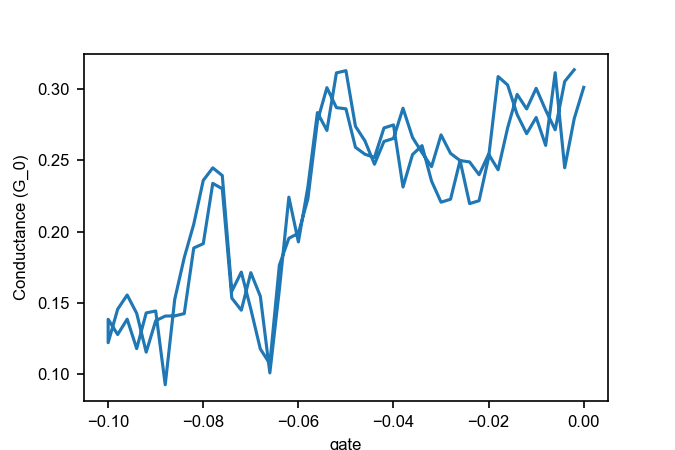

setting mdac in safe mode
Done
Starting experimental run with id: 1020
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during se

In [41]:
def setup():
    set_mdac_in_safemode()
    initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(0)
#    lockin_dc(10e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter([('current', 'A'), ('raw_voltage_dc', 'V'),('conductance', '2e^2/h'), ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V')])
def measure_acdc(gain=1e6, Rseries=13.4e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        #time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

gate_values = np.linspace(0, -0.1, 51)
gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_D6D3_QPC_pinchoff_5.5T_0bias",
    [(setup, ())],
    nest(       
        #sweep(ami_z.field, np.linspace(0, 5.5, 55)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
#         sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        sweep(mdac_gate_voltage, gate_values),
        #sweep(lockin_dc, np.linspace(15e-3, -15e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure_acdc
    ),
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"gate": 0, "Conductance (G_0)": 3}]
)

<IPython.core.display.Javascript object>


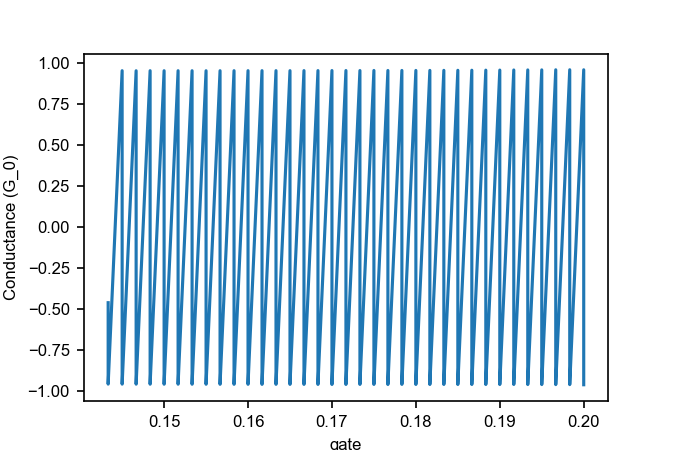

setting mdac in safe mode
Done
Starting experimental run with id: 949


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.2, right=0.2
  'left=%s, right=%s') % (left, right))


setting mdac in safe mode
Done


KeyboardInterrupt: 

In [47]:
def setup():
    set_mdac_in_safemode()
    initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(0.2)
    lockin_dc(15e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter([('current', 'A'), ('raw_voltage_dc', 'V'),('conductance', '2e^2/h'), ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V')])
def measure_acdc(gain=1e6, Rseries=13.4e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

#gate_values = np.linspace(1, -0.5, 201)
#gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_D6D3_QPC_gate_bias",
    [(setup, ())],
    nest(       
        #sweep(ami_z.field, np.linspace(5.5, 0, 56)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(15e-3, -15e-3, 100)),
        sweep(mdac_gate_voltage, np.linspace(0.2, -0.3, 301)),
        sweep(lockin_dc, np.linspace(15e-3, -15e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure_acdc
    ),
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"gate": 0, "Conductance (G_0)": 3}]
)

### $B$ field ramp to setpoint + monitor

<IPython.core.display.Javascript object>


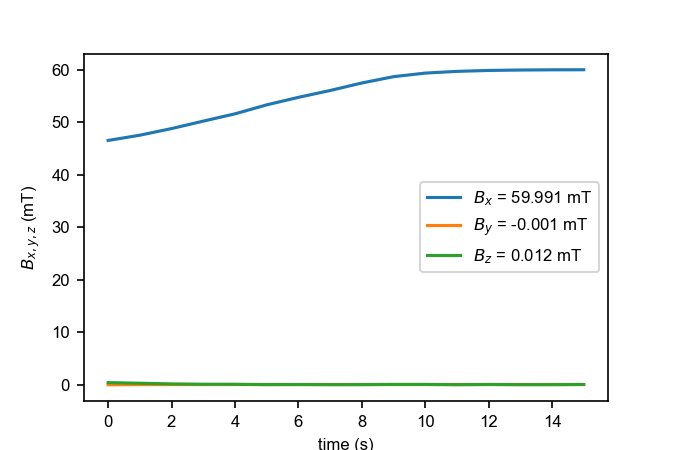

In [93]:
x_setpoint = 0.06#0E-3; # T
y_setpoint = 0E-3; # T
z_setpoint = 0E-3; # T

fig = plt.figure(0);
fig.clear();
fpl = fig.add_subplot(1, 1, 1);

Bx, By, Bz = [], [], [];
eps = 1E-5; # T

ami_x.ramp_rate(0.001); # T/s
ami_y.ramp_rate(0.0005); # T/s
ami_z.ramp_rate(0.001); # T/s

ami_x.ramp_to(x_setpoint);
ami_y.ramp_to(y_setpoint);
ami_z.ramp_to(z_setpoint);

while np.abs(x_setpoint - ami_x.field()) > eps or np.abs(y_setpoint - ami_y.field()) > eps or np.abs(z_setpoint - ami_z.field()) > eps:
    
    Bx.append(ami_x.field());
    By.append(ami_y.field());
    Bz.append(ami_z.field());
    
    fpl.clear();
    fpl.plot(range(0, len(Bx)), np.array(Bx) * 1E3, range(0, len(By)), np.array(By)*1E3, range(0, len(Bz)), np.array(Bz)*1E3);
    fpl.legend(('$B_x$ = {} mT'.format(str(round(Bx[-1]*1E3, 3))), '$B_y$ = {} mT'.format(str(round(By[-1]*1E3, 3))), '$B_z$ = {} mT'.format(str(round(Bz[-1]*1E3, 3)))));
    plt.xlabel('time (s)');
    plt.ylabel('$B_{x,y,z}$ (mT)');
    fig.canvas.draw();
    
    time.sleep(1);

In [94]:
print(ami_x.field())
print(ami_y.field())
print(ami_z.field())

0.0599987
-3.5e-06
2.38e-05


### Measure while ramping $B$

In [64]:
initialize(source, gate)

In [65]:
mdac_gate_voltage(0.2)

{'mdac_gate_voltage': 0.2}

<IPython.core.display.Javascript object>


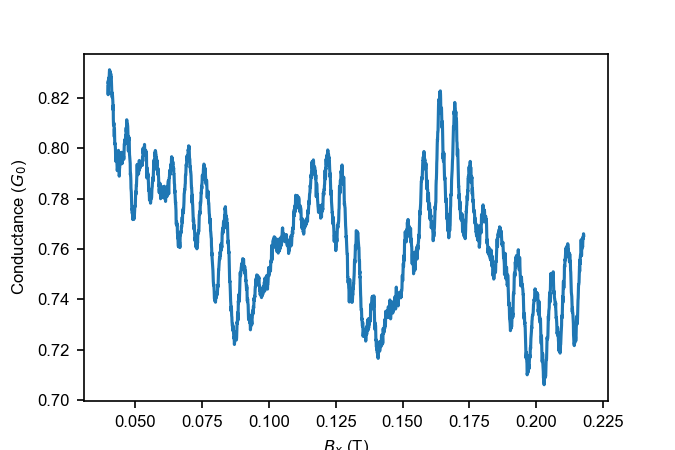

Starting experimental run with id: 1019
Initializing (blocking) field to 0.04 T ...
Sweeping (non-blocking) field to 0.22 T ...
Completed measurement. Database path: Q169_B15B13_ring_AB_0.2Vgate_170mK/0


In [132]:

def setup():
#     set_mdac_in_safemode()
#     initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
#     mdac_gate_voltage(0.2)
    #lockin_dc(10e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    sr1.time_constant(.1)
    #ami_x.field(0)
    time.sleep(1)
    ami_x.ramp_rate(0.0002) # T/s

    # Field setting and ramping should now be done automagically in the field_window function
    ami_x.ramp_to(0) # unit: T. non-blocking
#     ami_x.ramp_to(0.4) # unit: T. non-blocking

def cleanup(): 
    #pass
    ami_x.field(ami_x.field()) # stops the non-blocking field ramp
    sr1.amplitude(0)
    sr1.sine_outdc(0)
#     set_mdac_in_safemode()
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_z.field(0)

# Basically converts callable function to generator
def get_next(val):
    while 1:
        yield val();

# Generate linspace points until val() is outside of window        
def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
    linspace = np.linspace(start, stop, step)
    for value in linspace:

        if val() < (lowlim - eps) or val() > (highlim + eps):
            break

        yield value

# Sweep the field as long as val() is within the window
def field_window(magnet, lowlim, highlim, eps_multi = 0.01, init_to_closest_lim = True):

    val = magnet.field;

    # To correct for overshoot since the last window sweep of size eps, sweep field back to either
    # lowlim or highlim, whichever the current field value is closest to, then begin
    if init_to_closest_lim:

        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);

        print('Initializing (blocking) field to {} T ...'.format(initlim))
        magnet.field(initlim);
        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

    for field_val in get_next(val):
        if np.abs(field_val - finlim) < np.abs(eps):
                break

        yield field_val

@getter([('current', 'A'), ('raw_voltage_dc', 'V'),('conductance', '2e^2/h'), ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'), ('B_x', 'T')])
def measure_acdc(gain=1e6, Rseries=18.4e3, adder_atten=1e-2):
    time.sleep(0.02) 
    B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        #time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac, B_x
    return result

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_B15B13_ring_AB_0.2Vgate_170mK",
    [(setup, ())],
    nest(       
        #sweep(ami_x.field, np.linspace(0, 1, 5001)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, smart_linspace(0, 1, 4200, ami_x.field, 0.06, 0.16, 0.0025)),
        sweep(field_sweep, field_window(ami_x, 0.04, 0.22)),
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        #sweep(mdac_gate_voltage, gate_values),
        #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure_acdc
    ),
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"$B_x$ (T)": 9, "Conductance ($G_0$)": 3}]
)

### Back and forth sweep of $B$ at various gates

In [105]:
ami_x.field()

0.1626978

In [63]:
set_mdac_in_safemode()
sr1.amplitude(0)
sr1.sine_outdc(0)

setting mdac in safe mode
Done


setting mdac in safe mode
Done


<IPython.core.display.Javascript object>


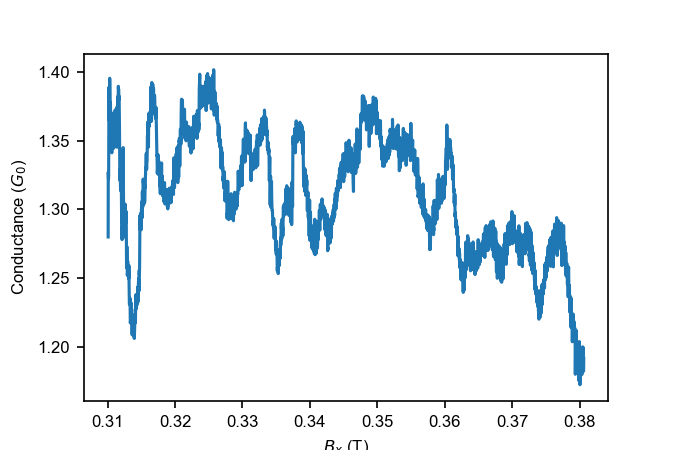

Starting experimental run with id: 966
Completed measurement. Database path: Q169_B15B13_ring_AB_stability_test_0.6gate_0bias_0.31T_to_0.38T/0


<IPython.core.display.Javascript object>


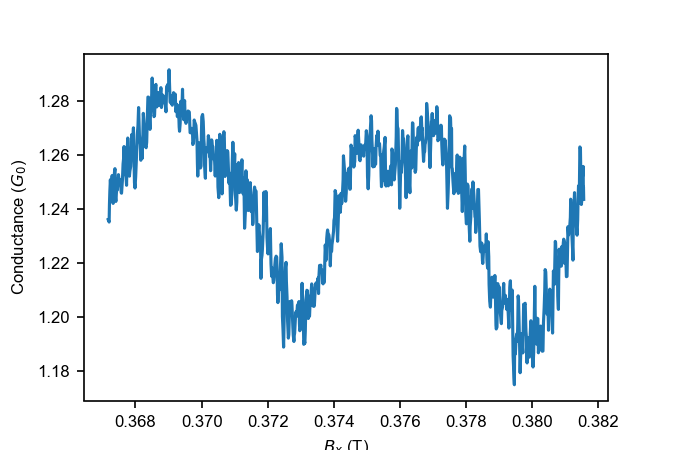

Starting experimental run with id: 967


KeyboardInterrupt: 

In [38]:
set_mdac_in_safemode()
initialize(source, gate)
sr1.amplitude(2e-3)

for sweep_counter in range(4):
    def setup():
        #set_mdac_in_safemode()
        #initialize(source, gate)
        #ami_z.field(5.5)
        #mdac.ch49.voltage(-3.5)
        #mdac.ch57.dac_output('close')
        #mdac.ch57.smc('close')
        key1.NPLC(1)
        #source.voltage(0.8) 
        #mdac_bias_voltage(5e-3)
        mdac_gate_voltage(0.6)# + sweep_counter*0.02)
        #lockin_dc(10e-3)
        #gate.voltage(0.8)
        #key2.NPLC(1)
        #ivvi.dac1(0)
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
        #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
        #sr1.frequency(117)     # adder HPF cutoff is 15Hz
        #sr1.phase(0)
        sr1.time_constant(.1)
        #ami_x.field(0)
        ami_x.ramp_rate(0.00007)
        time.sleep(1)
        if sweep_counter % 2 == 0: # first time (counter==0)
            ami_x.ramp_to(1) # non-blocking
        else:
            ami_x.ramp_to(0)

    def cleanup(): 
        pass
        #sr1.amplitude(0)
        #sr1.sine_outdc(0)
        #set_mdac_in_safemode()
        #mdac_voltage(0)
        #mdac.ch57.dac_output('open')
        #mdac.ch57.smc('open')
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #ivvi.dac1(0)    
        #yoko2.voltage(0)
        #ami_x.field(0)
        #ami_z.field(0)

    @getter([('current', 'A'), ('raw_voltage_dc', 'V'),('conductance', '2e^2/h'), ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'), ('B_x', 'T')])
    def measure_acdc(gain=1e6, Rseries=18.4e3, adder_atten=1e-2):
        time.sleep(0.02) 
        B_x = ami_x.field()
        key_raw = key1.volt()
        current_dc = -key_raw/gain
        #V_meas = key2.volt()
        #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
            #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
            #time.sleep(3)
            #print(sr1.X())
        Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
        #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
        L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
        L1R     = sr1.R()
        L1Y     = sr1.Y()
        # the above lines (excluding time.sleep) take at least 75ms to execute. 
        L1X     = sr1.X()
        current_ac = L1X/gain    
        g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
        #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
        result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac, B_x
        return result

    result = do_experiment(
    #     "NIS-Thermometer/SIM_10k",
        "Q169_B15B13_ring_AB_stability_test_0.6gate_0bias_0.31T_to_0.38T",#gate="+str(0.4 + sweep_counter*0.02),
        [(setup, ())],
        nest(       
            #sweep(ami_x.field, np.linspace(0, 1, 5001)),
            #sweep(sr1.frequency, np.linspace(80,130,41)),
            #sweep(gate.voltage, np.linspace(0, -3, 61)),
            sweep(time_sweep, np.linspace(0, 1, 4200)),  # make sure this takes longer than the field ramp
            #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
            #sweep(mdac_gate_voltage, gate_values),
            #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
            #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
            #sweep(mdac_gate_voltage, gate_points),
            measure_acdc
        ),
        [(cleanup, ())], 
        return_format=["data_set_path", "dataset"], 
        live_plot_axes=[{"$B_x$ (T)": 9, "Conductance ($G_0$)": 3}]
    )
                       
    time.sleep(10)

set_mdac_in_safemode()
sr1.amplitude(0)
sr1.sine_outdc(0)

## Miscellaneous/debugging 

In [ ]:
ramp(sr1.sine_outdc, 0, bias_ramp_stepsize, bias_ramp_delay)

In [ ]:
time_stamp_begin = time.time()
B_x = ami_x.field()
print(time.time()-time_stamp_begin)

In [ ]:
key1.volt()

In [ ]:
initialize(source,gate)

In [ ]:
gate.voltage()

In [ ]:
sr1.frequency()

In [ ]:
mdac_gate_voltage(0.8)

In [ ]:
sr1.amplitude(2e-3)

In [ ]:
r1 = mdac.ch58
r2 = mdac.ch62

In [ ]:
r2.dac_output('close')
r2.smc('close')

In [ ]:
r2.voltage(1e-3)

In [ ]:
r1.voltage(0)
r1.dac_output('open')
r1.smc('open')

In [ ]:
sr1.sine_outdc(0.0)

In [ ]:
mdac.ch58.dac_output('close')
mdac.ch58.smc('close')

In [ ]:
mdac.ch58.divider()

In [ ]:
initialize(source, gate)

In [ ]:
gate.voltage(0.8)

In [ ]:
key1.volt()

In [ ]:
ami_z.ramp_to(5)

In [ ]:
ami_x.field()

In [ ]:
timer = time.time()
key_raw = key1.volt()
current_dc = -key_raw/1e6
#V_meas = key2.volt()
#if np.abs(np.abs(sr1.sine_outdc())-0.05) < 12e-3:
    #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
    #time.sleep(3)
    #print(sr1.X())
L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter waiting time
L1R     = sr1.R()
L1Y     = sr1.Y()
#L1X     = sr1.X()
current_ac = L1R/1e6    # using R because of the phase introduced by operating below cutoff of adder HPF
Vac     = 1e-2*sr1.amplitude()  #*np.sqrt(2) 
#SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
#g       = 12906/(Vac/current_ac - 13e3) #[2e^2/h]
#result  = current_dc, key_raw, g, L1X, L1Y, V_meas
#result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
timer = time.time()-timer
print(timer)

In [ ]:
sr1.input_range()

## Field ramp exp

In [ ]:
from qcodes.sweep import sweep, getter, setter, \
    SweepMeasurement, nest, sweep_while, time_trace

In [ ]:
def not_at_setpoint(set_point, tolerance):
    
    @getter([
        ("field_x", "T"), 
        ("field_y", "T"),
        ("field_z", "T")
    ])
    def inner(): 
        fx = ami_x.field()
        fy = ami_y.field()
        fz = ami_z.field()
        
        if all([abs(fi - sp) < tolerance for fi, sp in zip([fx, fy, fz], set_point)]):
            return None, None, None
        
        return fx, fy, fz
    
    return inner 

def goto_setpoint(start_x, start_y, start_z, end_x, end_y, end_z):
    
    #Setting Starting points (waiting for end sweep, with block = True)
    print("setting x start")
    ami_x.set_field(start_x)
    print("setting y start")
    ami_y.set_field(start_y)
    print("setting z start")
    ami_z.set_field(start_z)
    
    #Going to end points
    print("setting x end")
    ami_x.set_field(end_x, block=False)
    print("setting y end")
    ami_y.set_field(end_y, block=False)
    print("setting z end")
    ami_z.set_field(end_z, block=False)

In [ ]:
start_Br = -0.140
end_Br =  -0.100
   
start_y = start_Br*np.sin(phi_offset_rad)
end_y = end_Br*np.sin(phi_offset_rad)
start_x = start_Br*np.cos(phi_offset_rad)
end_x = end_Br*np.cos(phi_offset_rad)
start_z = 4.
end_z = 4.
print('x_start:', start_x)
print('y_start:', start_y)
print('x_end:', end_x)
print('y_end:', end_y)

ramp_factor = 1.0                #to prevent heating is less than 1
ramp_y = ramp_factor*0.0001452   #0.0001452 original rate for y magnet, do not touch
ami_y.ramp_rate(ramp_y)
ramp_x = ami_y.ramp_rate()*np.abs((end_x-start_x)/(end_y-start_y))
ami_x.ramp_rate(ramp_x)
print('New rates are:')
print('rate y:',ramp_y)
print('rate x:',ramp_x)
expected_time = (np.abs(end_y-start_y)/ramp_y)/60.0  #expected time in minutes
print('Total measurement time:', np.round(expected_time, 2), 'minutes.')  
print('Total measurement time:', np.round(expected_time/60.0, 2), 'hours.') 

sweep_object = nest(
    time_trace(
        sweep_while(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
        interval_time=0.6, # measure every n second
        total_time=None  # We do not have an end time; run until the SweepWhile is done
    ), 
    measure_DC  # use this measurement function
)

live_plot_axes = {"field y": 2, "conductance": 8}

dataid = DoExperiment(
    "device1", 
    [
        (init_DC, ()), 
        (set_params, ()), 
        (goto_setpoint, (start_x, start_y, start_z, end_x, end_y, end_z))
    ], 
    sweep_object, 
    [
        (end_DC, ())
    ], 
    out_file = "device1_{counter}.txt",
    live_plot_axes=[live_plot_axes]
)

In [ ]:
def setup():
    set_mdac_in_safemode()
    #initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    #mdac_gate_voltage(-0.5)
    #lockin_dc(10e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    ami_x.ramp_to(0.02)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter([('current', 'A'), ('raw_voltage_dc', 'V'),('conductance', '2e^2/h'), ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V')])
def measure_acdc(gain=1e6, Rseries=13.4e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        #time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

tolerance = 1e-3
end_x = 0.02
end_y = 0
end_z = 0

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_ramp_magnet_sweepwhile",
    [(setup, ())],
    nest(       
        #sweep(ami_z.field, np.linspace(0, 5.5, 55)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        #weep(mdac_gate_voltage, np.linspace(-0.5,-1, 51)),
        #sweep(lockin_dc, np.linspace(15e-3, -15e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        time_trace(
            sweep_while(not_at_setpoint((end_x, end_y, end_z), tolerance)), # Take a time trace while we are not at the end point
            interval_time=0.1, # measure every n second
            total_time=None  # We do not have an end time; run until the SweepWhile is done
        ),
        measure_acdc
    ),
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"gate": 0, "Conductance (G_0)": 3}]
)

In [133]:
mdac_gate_voltage(0)

{'mdac_gate_voltage': 0}

In [134]:
set_mdac_in_safemode()

setting mdac in safe mode
Done
